In [ ]:
import os
import time
import warnings
import shutil
from tempfile import TemporaryDirectory

import pandas as pd
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
from torchvision import datasets, models, transforms
from torchvision.models import efficientnet_b3

from transformers import RobertaModel, RobertaTokenizer

from tqdm.auto import tqdm

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

plt.ion() # interactive mode

warnings.filterwarnings('ignore')

## Download data

In [2]:
train_df = pd.read_csv('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/train.csv')
test_df = pd.read_csv('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/test.csv')

In [3]:
# set label range [0,3] instead of [1,4]
train_df['AdoptionSpeed'] = train_df['AdoptionSpeed'] - 1

In [4]:
train_df

,PetID,Description,AdoptionSpeed
0,d3b4f29f8,Mayleen and Flo are two lovely adorable sister...,1
1,e9dc82251,A total of 5 beautiful Tabbys available for ad...,1
2,8111f6d4a,Two-and-a-half month old girl. Very manja and ...,1
3,693a90fda,Neil is a healthy and active ~2-month-old fema...,1
4,9d08c85ef,Gray kitten available for adoption in sungai p...,1
...,...,...,...
6426,440676acb,Puppy was rescued in the monsoon drain near my...,1
6427,62550cf78,Please contact if you are interested.,0
6428,a062234cb,4/1/ An adorable domestic medium hair kitten l...,3
6429,7a54b760e,6 Jan :30: We found this poor dog (male) wande...,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6431 entries, 0 to 6430
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   PetID          6431 non-null   object
 1   Description    6426 non-null   object
 2   AdoptionSpeed  6431 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 150.9+ KB


In [6]:
# Fill in nan values  with empty string
train_df['Description'].fillna('', inplace=True)

In [7]:
name_target_dict = train_df.set_index('PetID')['AdoptionSpeed'].to_dict()
train_image_names = os.listdir('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/train')
test_image_names = os.listdir('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/test')

Displayed images average size: 443.0833333333333x426.0833333333333


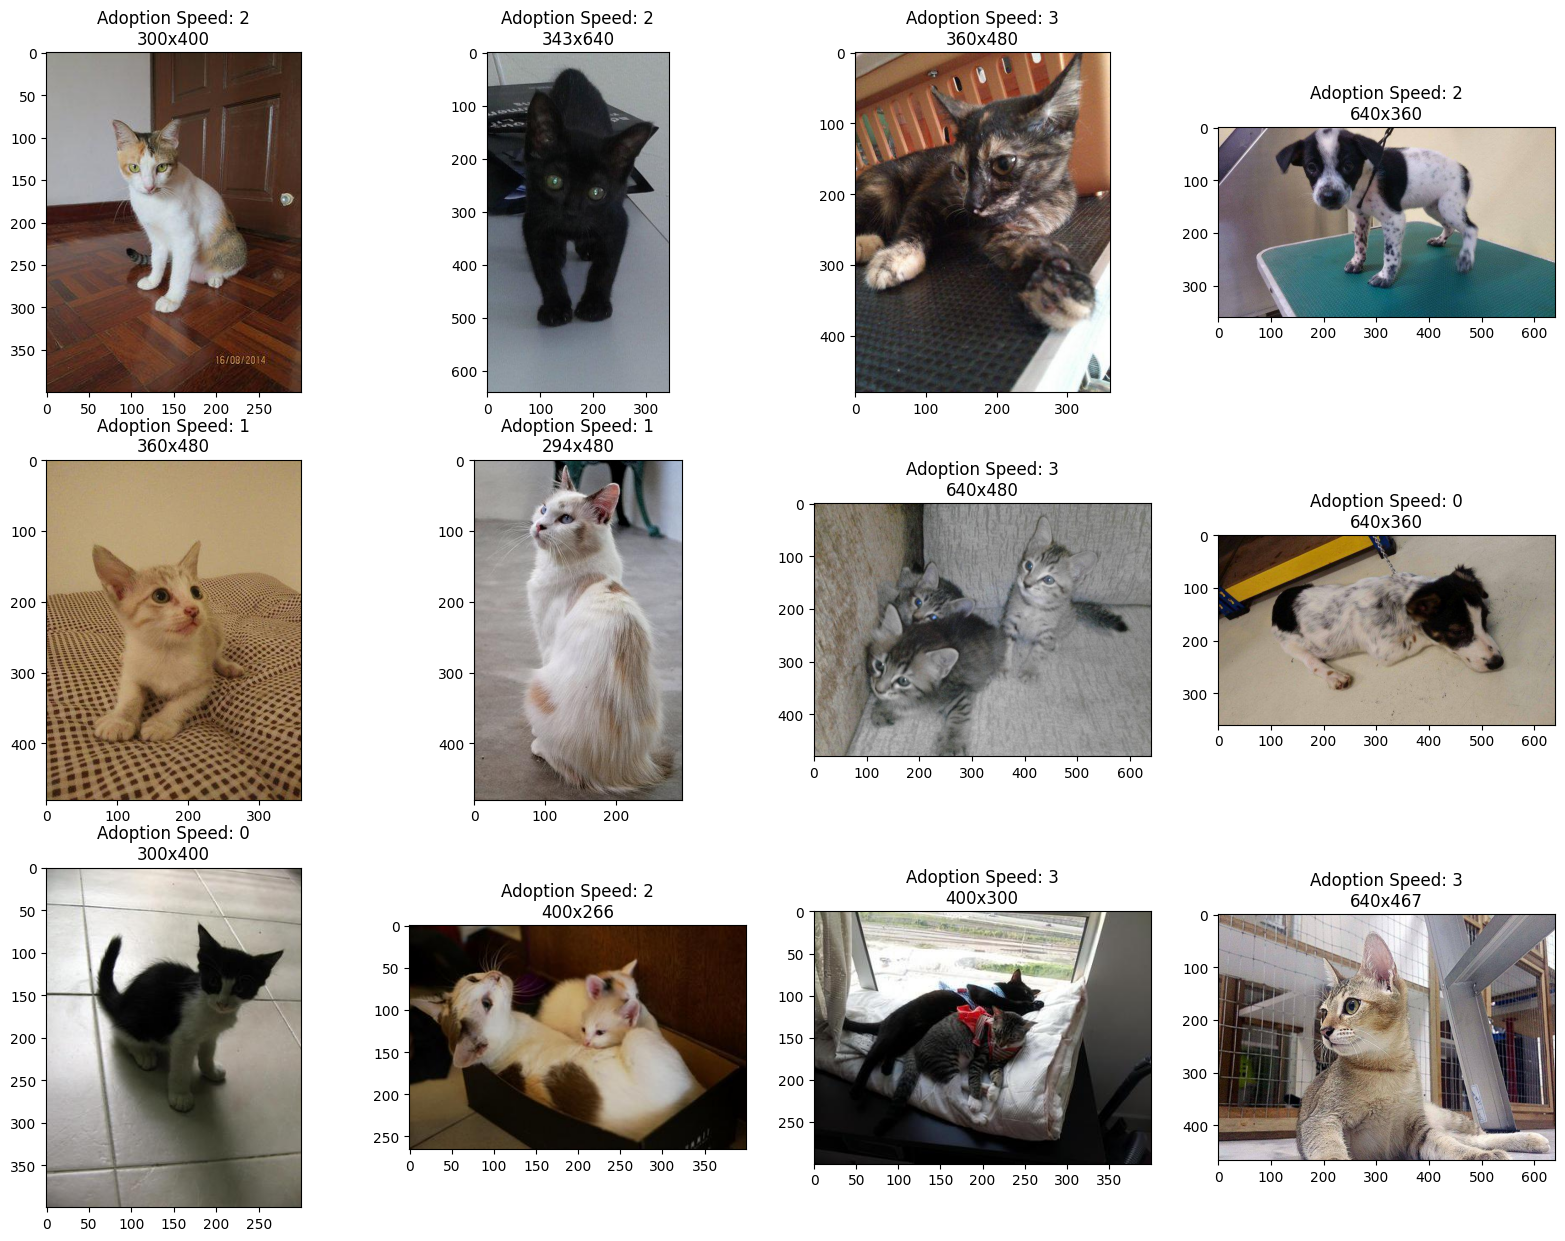

In [66]:
# Visualize image samples
name_target_dict = train_df.set_index('PetID')['AdoptionSpeed'].to_dict()
train_image_names = os.listdir('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/train')
test_image_names = os.listdir('/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/test')

def display_samples_and_analyze_size(columns=4, rows=3):
    fig = plt.figure(figsize=(5*columns, 5*rows))
    widths = []
    heights = []
    
    for i in range(columns*rows):
        if i >= len(train_image_names):
            break  # Prevent index out of range
        image_path = train_image_names[i]
        pet_id = image_path.split('-')[0]
        
        # Check if the PetID exists in name_target_dict
        if pet_id not in name_target_dict:
            print(f"PetID {pet_id} not found in dictionary, skipped")
            continue  # Skip this image
        
        image_id = name_target_dict[pet_id]
        img = cv2.imread(f'/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/train/{image_path}')
        
        if img is None:
            print(f"Image at {image_path} N/A, skipped")
            continue  # Skip if image cannot be loaded
        
        height, width, _ = img.shape
        widths.append(width)
        heights.append(height)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(f"Adoption Speed: {image_id}\n{width}x{height}")
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        
    avg_width = np.mean(widths)
    avg_height = np.mean(heights)
    print(f"Displayed images average size: {avg_width}x{avg_height}")
    
    return widths, heights

# Call the function and receive the size data
widths, heights = display_samples_and_analyze_size()

In [8]:
# Check if all pets have an image
train_no_image_pets = []
test_no_image_pets = []

for idx, row in train_df.iterrows():
    pet_id = row['PetID']
    
    # Search all images with this PetID
    images_found = False
    for img_file in train_image_names:
        if img_file.startswith(pet_id):
            images_found = True
            break
    
    if not images_found:
        train_no_image_pets.append(pet_id)

if train_no_image_pets:
    print(f"Pets without images in train set: {len(train_no_image_pets)}")
    print(train_no_image_pets)
else:
    print("All pets in train set have an image")

for idx, row in test_df.iterrows():
    pet_id = row['PetID']
    
    # Search all images with this PetID
    images_found = False
    for img_file in test_image_names:
        if img_file.startswith(pet_id):
            images_found = True
            break
    
    if not images_found:
        test_no_image_pets.append(pet_id)

if test_no_image_pets:
    print(f"Pets without images in test set: {len(test_no_image_pets)}")
    print(test_no_image_pets)
else:
    print("All pets in test set have an image")

All pets in train set have an image
Pets without images in test set: 4
['95314294', '35992662', '63521459', '81301773']


## Splitting data into train and test sets

In [9]:
train_set, val_set = train_test_split(train_df, test_size=0.05, random_state=42)

# Directory for training images
train_image_dir = '/kaggle/working/train_images/'
os.makedirs(train_image_dir, exist_ok=True)

# Directory for validation images
val_image_dir = '/kaggle/working/val_images/'
os.makedirs(val_image_dir, exist_ok=True)

In [10]:
source_image_dir = '/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/train'

# Function for copying images to working directory
def copy_images(pet_ids, dest_dir):
    for pet_id in pet_ids:
        # Search images referred to this PetID
        for img_file in os.listdir(source_image_dir):
            if img_file.startswith(pet_id):
                # Copy images to target directory
                shutil.copy(os.path.join(source_image_dir, img_file), os.path.join(dest_dir, img_file))

# Copy train images
copy_images(train_set['PetID'], train_image_dir)

# Copy validation images
copy_images(val_set['PetID'], val_image_dir)

print(f"Train images: {len(os.listdir(train_image_dir))}")
print(f"Validation images: {len(os.listdir(val_image_dir))}")

Train images: 27114
Validation images: 1358


In [11]:
# Expand train and val sets by taking several pictures for each pet and duplicating corresponding text and labels

# function for collecting all image paths for the pet by id
def get_image_paths(pet_id, image_dir):
    image_paths = []
    for i in range(1, 5):  # Let's take 5 images for each pet 
        image_path = f"{image_dir}/{pet_id}-{i}.jpg"
        if os.path.exists(image_path):
            image_paths.append(image_path)
        else:
            break
    return image_paths

expanded_train_data = []

for idx, row in train_set.iterrows():
    pet_id = row['PetID']
    image_paths = get_image_paths(pet_id, train_image_dir)
    
    # add new row for each image
    for image_path in image_paths:
        new_row = row.copy()
        new_row['image_path'] = image_path  # add image path
        expanded_train_data.append(new_row)

# create new DataFrame with expanded data
expanded_train_df = pd.DataFrame(expanded_train_data)
expanded_train_df = expanded_train_df.reset_index(drop=True)

print(len(expanded_train_df))
expanded_train_df.head(10)

18324


,PetID,Description,AdoptionSpeed,image_path
0,ea03ccbba,Xindie is a very alert dog and she is very int...,3,/kaggle/working/train_images//ea03ccbba-1.jpg
1,ea03ccbba,Xindie is a very alert dog and she is very int...,3,/kaggle/working/train_images//ea03ccbba-2.jpg
2,ea03ccbba,Xindie is a very alert dog and she is very int...,3,/kaggle/working/train_images//ea03ccbba-3.jpg
3,ea03ccbba,Xindie is a very alert dog and she is very int...,3,/kaggle/working/train_images//ea03ccbba-4.jpg
4,03f0fc32f,Momma is an amazing dog looking for a great ho...,3,/kaggle/working/train_images//03f0fc32f-1.jpg
5,03f0fc32f,Momma is an amazing dog looking for a great ho...,3,/kaggle/working/train_images//03f0fc32f-2.jpg
6,03f0fc32f,Momma is an amazing dog looking for a great ho...,3,/kaggle/working/train_images//03f0fc32f-3.jpg
7,03f0fc32f,Momma is an amazing dog looking for a great ho...,3,/kaggle/working/train_images//03f0fc32f-4.jpg
8,efbe1f3ef,Keeping 4 healthy kittens waiting for adoption...,1,/kaggle/working/train_images//efbe1f3ef-1.jpg
9,efbe1f3ef,Keeping 4 healthy kittens waiting for adoption...,1,/kaggle/working/train_images//efbe1f3ef-2.jpg


In [12]:
# Expand val dataset in the same way
expanded_val_data = []

for idx, row in val_set.iterrows():
    pet_id = row['PetID']
    image_paths = get_image_paths(pet_id, val_image_dir)
    
    # add new row for each image
    for image_path in image_paths:
        new_row = row.copy()
        new_row['image_path'] = image_path  # add image path
        expanded_val_data.append(new_row)

# create new DataFrame with expanded data
expanded_val_df = pd.DataFrame(expanded_val_data)
expanded_val_df = expanded_val_df.reset_index(drop=True)

print(len(expanded_val_df))
expanded_val_df.head(10)

932


,PetID,Description,AdoptionSpeed,image_path
0,1a030d758,Mickey is found without a mother with another ...,1,/kaggle/working/val_images//1a030d758-1.jpg
1,1a030d758,Mickey is found without a mother with another ...,1,/kaggle/working/val_images//1a030d758-2.jpg
2,1a030d758,Mickey is found without a mother with another ...,1,/kaggle/working/val_images//1a030d758-3.jpg
3,1a030d758,Mickey is found without a mother with another ...,1,/kaggle/working/val_images//1a030d758-4.jpg
4,0c3ce1826,CACA rapat dengan Coo Coo. apapun benda yang d...,1,/kaggle/working/val_images//0c3ce1826-1.jpg
5,0c3ce1826,CACA rapat dengan Coo Coo. apapun benda yang d...,1,/kaggle/working/val_images//0c3ce1826-2.jpg
6,0c3ce1826,CACA rapat dengan Coo Coo. apapun benda yang d...,1,/kaggle/working/val_images//0c3ce1826-3.jpg
7,0c3ce1826,CACA rapat dengan Coo Coo. apapun benda yang d...,1,/kaggle/working/val_images//0c3ce1826-4.jpg
8,3f834da3b,thank already adoption :) lucky star find a ne...,0,/kaggle/working/val_images//3f834da3b-1.jpg
9,3f834da3b,thank already adoption :) lucky star find a ne...,0,/kaggle/working/val_images//3f834da3b-2.jpg


## Create datasets and dataloaders

In [13]:
class MultimodalDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, image_dir, transform=None, image_size=(300, 300)):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.image_dir = image_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.image_size = image_size

    def __len__(self):
        return len(self.dataframe)

    def get_dummy_image(self):
        """Create dummy image for pets without photo"""
        dummy_image = Image.new('RGB', self.image_size, color=(0, 0, 0))
        return self.transform(dummy_image)

    def __getitem__(self, idx):
        # Extract text and labels
        text = self.dataframe.iloc[idx]['Description']
        label = torch.tensor(self.dataframe.iloc[idx]['AdoptionSpeed'], dtype=torch.long)

        # Text tokenization
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        # Extract images
        image_path = self.dataframe.iloc[idx]['image_path']
        pet_id = self.dataframe.iloc[idx]['PetID']
        #image_path = f"{self.image_dir}/{pet_id}-1.jpg"  # Use the first image only
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
        except FileNotFoundError:
            image = self.get_dummy_image()
            print(f'Image for {pet_id} is absent, used dummy image')

        return {
            'text_inputs': input_ids,
            'attention_mask': attention_mask,
            'image_inputs': image,
            'labels': label
        }


In [36]:
# Use pretrained tokenizer for roberta model for text
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
max_len = 128
batch_size = 16

# image processing
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((300,300)),
        transforms.AutoAugment(transforms.AutoAugmentPolicy.IMAGENET),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=5),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        #transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((300,300)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset =  MultimodalDataset(expanded_train_df, tokenizer, max_len, train_image_dir, transform=data_transforms['train'])
val_dataset = MultimodalDataset(expanded_val_df, tokenizer, max_len, val_image_dir, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


## Model structure

In [45]:
class CrossAttentionLayer(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(CrossAttentionLayer, self).__init__()
        # Cross-Attention implementation from pytorch
        self.cross_attention = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, query, key, value):
        # Apply cross attention
        attn_output, _ = self.cross_attention(query, key, value)
        return attn_output

class MultimodalCrossAttentionNet(nn.Module):
    def __init__(self, num_classes):
        super(MultimodalCrossAttentionNet, self).__init__()

        # Text module - RoBERTa
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        
        # Image module - EfficientNet
        efficientnet = efficientnet_b3(pretrained=True)
        self.efficientnet = nn.Sequential(*list(efficientnet.children())[:-1])  # Remove last classification layer

        # Linear layers for transforming text and visual features before cross-attention
        self.text_projection = nn.Linear(768, 512)  # RoBERTa gives 768 features, project to  512
        self.image_projection = nn.Linear(1536, 512)  # EfficientNet-B3 gives 1536 features, project to  512

        # Cross-Attention 
        self.cross_attention_text_to_image = CrossAttentionLayer(embed_dim=512, num_heads=8) # 8 attention heads
        self.cross_attention_image_to_text = CrossAttentionLayer(embed_dim=512, num_heads=8)

        # Dense layers for combined features
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, num_classes)

        # Additinal layers 
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
     
        
    def forward(self, text_inputs, attention_mask, image_inputs):
        # Extract text features from RoBERTa
        roberta_output = self.roberta(input_ids=text_inputs, attention_mask=attention_mask)
        text_features = roberta_output.last_hidden_state[:, 0, :]  # Используем CLS токен

        # transform text features through linear layer
        text_features = self.text_projection(text_features)

        # Extract image features from EfficientNet
        image_features = self.efficientnet(image_inputs)
        image_features = image_features.view(image_features.size(0), -1)  # transform to vector [batch_size, 1536]
        
        # transform image features through linear layer
        image_features = self.image_projection(image_features)

        # Apply Cross-Attention
        # 1. Text features influence image features
        image_features_attn = self.cross_attention_text_to_image(image_features.unsqueeze(0), text_features.unsqueeze(0), text_features.unsqueeze(0))
        image_features_attn = image_features_attn.squeeze(0)

        # 2.Image features influence text features
        text_features_attn = self.cross_attention_image_to_text(text_features.unsqueeze(0), image_features.unsqueeze(0), image_features.unsqueeze(0))
        text_features_attn = text_features_attn.squeeze(0)

        # Combine features
        #combined_features = torch.cat((text_features, image_features), dim=1)
        combined_features = text_features_attn + image_features_attn

        # Classification
        x = self.fc1(combined_features)
        x = self.dropout(x)
        x = self.fc2(x) 
        return x

In [21]:
# Functions for calculating quadratic weighted kappa

def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    """
    Returns the confusion matrix between rater's ratings
    """
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat


def histogram(ratings, min_rating=None, max_rating=None):
    """
    Returns the counts of each type of rating that a rater made
    """
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings


def quadratic_weighted_kappa(y, y_pred):
    """
    Calculates the quadratic weighted kappa
    axquadratic_weighted_kappa calculates the quadratic weighted kappa
    value, which is a measure of inter-rater agreement between two raters
    that provide discrete numeric ratings.  Potential values range from -1
    (representing complete disagreement) to 1 (representing complete
    agreement).  A kappa value of 0 is expected if all agreement is due to
    chance.
    quadratic_weighted_kappa(rater_a, rater_b), where rater_a and rater_b
    each correspond to a list of integer ratings.  These lists must have the
    same length.
    The ratings should be integers, and it is assumed that they contain
    the complete range of possible ratings.
    quadratic_weighted_kappa(X, min_rating, max_rating), where min_rating
    is the minimum possible rating, and max_rating is the maximum possible
    rating
    """
    rater_a = y
    rater_b = y_pred
    min_rating=None
    max_rating=None
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert(len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b,
                                min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (hist_rater_a[i] * hist_rater_b[j]
                              / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items

    return (1.0 - numerator / denominator)


# Model training

In [46]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    model = model.to(device)
    best_qwk = -float('inf')
    
    def lambda_lr(epoch):
        if epoch == 0:
            return 1  # lr=1e-4 on first epoch
        else:
        # Decreasing on 2-nd and 3-rd epoch
            return 0.1 + 0.9 * (1 - (epoch - 1) / 2)  # from 1e-4 to 1e-5

    # Create castom scheduler
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_lr)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train_preds = 0
        total_train_preds = 0
        
        train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]", leave=False)

        for batch in train_loop:
            text_inputs = batch['text_inputs'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            image_inputs = batch['image_inputs'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(text_inputs, attention_mask, image_inputs)
            
            # Loss calculation
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            # Predictions
            _, preds = torch.max(outputs, 1)
            correct_train_preds += torch.sum(preds == labels).item()
            total_train_preds += labels.size(0)
            
            train_loop.set_postfix(loss=running_loss/len(train_loader), accuracy=correct_train_preds/total_train_preds)

        train_accuracy = correct_train_preds / total_train_preds
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}, Train Accuracy: {train_accuracy:.4f}")

        # Validation after each epoch
        model.eval()
        val_loss = 0.0
        correct_val_preds = 0
        total_val_preds = 0
        all_labels = []
        all_preds = []
        
        val_loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]", leave=False)
        
        with torch.no_grad():
            for batch in val_loop:
                text_inputs = batch['text_inputs'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                image_inputs = batch['image_inputs'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(text_inputs, attention_mask, image_inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # Predictions
                _, preds = torch.max(outputs, 1)
                correct_val_preds += torch.sum(preds == labels).item()
                total_val_preds += labels.size(0)

                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                
                val_loop.set_postfix(val_loss=val_loss/len(val_loader), val_accuracy=correct_val_preds/total_val_preds)


        val_accuracy = correct_val_preds / total_val_preds
        qwk_score = quadratic_weighted_kappa(all_labels, all_preds)
        print(f"Validation Loss: {val_loss/len(val_loader)}, Validation Accuracy: {val_accuracy:.4f}, QWK: {qwk_score:.4f}")
        
        # Save the model if QWK got better
        if qwk_score > best_qwk:
            best_qwk = qwk_score
            torch.save(model.state_dict(), '/kaggle/working/best_model_state.pth')
            print(f"New best model saved with QWK: {qwk_score:.4f}")
        
        
        torch.cuda.empty_cache() # After each epoch clear cash of cuda
        gc.collect()

        scheduler.step()


In [47]:
num_epochs = 3
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = MultimodalCrossAttentionNet(num_classes=4)  
   
criterion = torch.nn.CrossEntropyLoss(label_smoothing = 0.1)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3 [Training]:   0%|          | 0/1146 [00:00<?, ?it/s]

Epoch 1/3, Loss: 1.2830570523235394, Train Accuracy: 0.4216


Epoch 1/3 [Validation]:   0%|          | 0/59 [00:00<?, ?it/s]

Validation Loss: 1.2126624897374945, Validation Accuracy: 0.4796, QWK: 0.5315
New best model saved with QWK: 0.5315


Epoch 2/3 [Training]:   0%|          | 0/1146 [00:00<?, ?it/s]

Epoch 2/3, Loss: 1.2246070532274496, Train Accuracy: 0.4744


Epoch 2/3 [Validation]:   0%|          | 0/59 [00:00<?, ?it/s]

Validation Loss: 1.2229789859157498, Validation Accuracy: 0.4592, QWK: 0.5053


Epoch 3/3 [Training]:   0%|          | 0/1146 [00:00<?, ?it/s]

Epoch 3/3, Loss: 1.1370309595454218, Train Accuracy: 0.5409


Epoch 3/3 [Validation]:   0%|          | 0/59 [00:00<?, ?it/s]

Validation Loss: 1.2255615642515278, Validation Accuracy: 0.4936, QWK: 0.5049


In [49]:
for param in model.roberta.encoder.layer[-1:].parameters():  # Unfreeze last layer of Roberta
    param.requires_grad = True

for param in model.efficientnet[-2:].parameters():  # Unfreze last 2 layers of EfficientNet
    param.requires_grad = True

# Learn with unfreezed layers and decreased learning rate
model = MultimodalCrossAttentionNet(num_classes=4) 
model.load_state_dict(torch.load('/kaggle/working/best_model_state.pth'))
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-6)  # decrease lr

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1, device=device)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/1 [Training]:   0%|          | 0/1146 [00:00<?, ?it/s]

Epoch 1/1, Loss: 1.2190996419904951, Train Accuracy: 0.4755


Epoch 1/1 [Validation]:   0%|          | 0/59 [00:00<?, ?it/s]

Validation Loss: 1.2014875876701485, Validation Accuracy: 0.4818, QWK: 0.5286
New best model saved with QWK: 0.5286


In [50]:
# Unfreeze all layers
for param in model.roberta.parameters():
    param.requires_grad = True

for param in model.efficientnet.parameters():
    param.requires_grad = True

# Learn model with very low learning rate
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-7)
# model = MultimodalNet(num_classes=4) 
# model.load_state_dict(torch.load('/kaggle/working/best_model_state.pth'))

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=1, device=device)

Epoch 1/1 [Training]:   0%|          | 0/1146 [00:00<?, ?it/s]

Epoch 1/1, Loss: 1.2096812977840763, Train Accuracy: 0.4837


Epoch 1/1 [Validation]:   0%|          | 0/59 [00:00<?, ?it/s]

Validation Loss: 1.2036281258372936, Validation Accuracy: 0.4828, QWK: 0.5283
New best model saved with QWK: 0.5283


## Predictions on test set

In [51]:
test_df

,PetID,Description
0,6697a7f62,This cute little puppy is looking for a loving...
1,23b64fe21,These 3 puppies was rescued from a mechanic sh...
2,41e824cbe,"Ara needs a forever home! Believe me, he's a r..."
3,6c3d7237b,i rescue this homeless dog 2 years ago but my ...
4,97b0b5d92,We found him at a shopping mall at a very clea...
...,...,...
1886,986e26eeb,"Give a stray kitten a home, and you just may b..."
1887,9b2316d19,Reno is very affectionate and a playful boy. H...
1888,c60193e34,Spot is very active and playful. She likes to ...
1889,4f7a70728,"hello, can u give me a loving and warm forever..."


In [52]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1891 entries, 0 to 1890
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PetID        1891 non-null   object
 1   Description  1890 non-null   object
dtypes: object(2)
memory usage: 29.7+ KB


In [53]:
test_df['Description'].fillna('', inplace=True)

In [54]:
class MultimodalTestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, image_dir, transform=None, image_size=(300, 300)):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.image_dir = image_dir
        self.transform = transform if transform else transforms.ToTensor()
        self.image_size = image_size

    def __len__(self):
        return len(self.dataframe)

    def get_dummy_image(self):
        """Create dummy image for pets without photo"""
        dummy_image = Image.new('RGB', self.image_size, color=(0, 0, 0))
        return self.transform(dummy_image)

    def __getitem__(self, idx):
        # Extract text
        text = self.dataframe.iloc[idx]['Description']

        # Tokenization of text
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        input_ids = encoding['input_ids'].flatten()
        attention_mask = encoding['attention_mask'].flatten()

        # Extract images
        pet_id = self.dataframe.iloc[idx]['PetID']
        image_path = f"{self.image_dir}/{pet_id}-1.jpg"  # Use only first image for prediction
        try:
            image = Image.open(image_path).convert('RGB')
            image = self.transform(image)
        except FileNotFoundError:
            image = self.get_dummy_image()

        return {
            'text_inputs': input_ids,
            'attention_mask': attention_mask,
            'image_inputs': image
        }


In [55]:
test_dataset = MultimodalTestDataset(
    dataframe=test_df,
    tokenizer=tokenizer,
    max_len=128,
    image_dir='/kaggle/input/deep-learning-for-computer-vision-and-nlp-2024-10/images/images/test',
    transform=data_transforms['val']
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [57]:
def predict_and_save(model, test_loader, device, output_csv_path, test_df):
    model.eval()  
    predictions = []
    pet_ids = test_df['PetID'].tolist()  # get list of PetIDs 

    with torch.no_grad():
        for batch in test_loader:
            text_inputs = batch['text_inputs'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            image_inputs = batch['image_inputs'].to(device)

            model = model.to(device)
            outputs = model(text_inputs, attention_mask, image_inputs)
            
            # Get probabilities and predictions
            probs = torch.softmax(outputs, dim=1)
            preds = torch.argmax(probs, dim=1)  # get predictions

            predictions.extend(preds.cpu().numpy())  # Save predictions to list

    # Create a DataFrame with PetIDs and predictions of AdoptionSpeed
    result_df = pd.DataFrame({
        'PetID': pet_ids,
        'AdoptionSpeed': predictions
    })

    # Save to CSV
    result_df['AdoptionSpeed'] = result_df['AdoptionSpeed'] + 1 # add 1 to return to range [1,4] instead of [0,3]
    result_df.to_csv(output_csv_path, index=False)

model = MultimodalCrossAttentionNet(num_classes=4) 
model.load_state_dict(torch.load('/kaggle/working/best_model_state.pth'))
output_csv_path = 'submission.csv'

predict_and_save(model, test_loader, device, output_csv_path, test_df)
print(f"Predictions saved in {output_csv_path}")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Predictions saved in submission.csv


In [59]:
submission = pd.read_csv('/kaggle/working/submission.csv')
submission.head(10)

,PetID,AdoptionSpeed
0,6697a7f62,4
1,23b64fe21,2
2,41e824cbe,4
3,6c3d7237b,4
4,97b0b5d92,4
5,5eb355cea,4
6,bf2b57c9d,2
7,4f6029457,1
8,fe09dbb56,2
9,9b3e95995,4


## Readme 

Для прогнозування швидкості адопції тваринок була побудована кастомна мультимодальна модель, що включала в себе екстрактор текстових ознак у вигляді натренованої моделі Roberta base та ексрактор ознак з зображення - натреновану модель EfficientNet B3.


Попередня обробка даних включала заповнення пропущених текстових описів пустим рядком, токенізація тексту за допомогою токенізатора для Roberta, застосування ряду трансформацій до зображень, включаючи зміну розміру та аугментацію тренувальних зображень. Оскільки кожна тварина могла мати від 1 до кілька десятків фото, тренувальний та валідаційний датасети розширено: взято до 5 зображень для кожної тварирнки, відповідні ID, текстові описи, та мітки скопійовано. Таким чином, розмір тренувального набору збільшений до 18324 рядків (і 932 на валідацію), хоча оригінальний тренувальний датасет містить лише 6431 об'єкт.


Класифікаційна частина моделі включає 2 лінійні шари, що приймають агреговані ознаки з тексту та зоборажень (вектори текстових та візуальних ознак були поелементно просумовані замість конкатенації) та мають 4 виходи - по одному на кожен клас. Модель також включає механізм перехресної уваги за аналогією механізму уваги в трансформерах. Текстові ознаки впливають на візуальні за допомогою механізму багатоголової уваги (MultiheadAttention). Візуальні ознаки впливають на текстові за допомогою іншої багатоголової уваги. 
Використовується дропаут для регуляризації та RELU для активації. Як функція втрат була застосована CrossEntropyLoss із згладжуванням міток задля зниження перенавчання.

Під час тренування застосовано кастомний lr-scheduler, що знижує learning rate з 1e-4 на першій епосі до 1e-5 на третій епосі. Роморожено останні 2 шари екстрактора візуальнихх ознак та 1 останній шар екстрактора текстових ознак.

Модель навчалася протягом лише 3 епох з причин схильності до перенавчання, зберігається лише модель в разі покращення метрики quadratic weighted kappa на валідаційному наборі (часто покращення наступало тільки на першій епосі). Застосований метод поступового розмороження ваг в екстракторах ознак із зниженням learning rate. Кращу збережену модель натреновано протягом однієї епохи із розмороженими останніми шарами екстракторів та learning rate  1e-6, а потім ще одну епоху з повністю розмороженими вагами із learning rate 1e-7.

Для прогнозування міток у тестовому датасеті було використано лише перше зображення з доступних. Створено тестовий dataset та dataloader, завантажено збережену найкращу модель, здійснено forward pass крізь завантажену модель, отримані пронози збережені у файл submission.csv